Numero di file audio trovati: 1


Processing audio files:   0%|          | 0/1 [00:00<?, ?it/s]

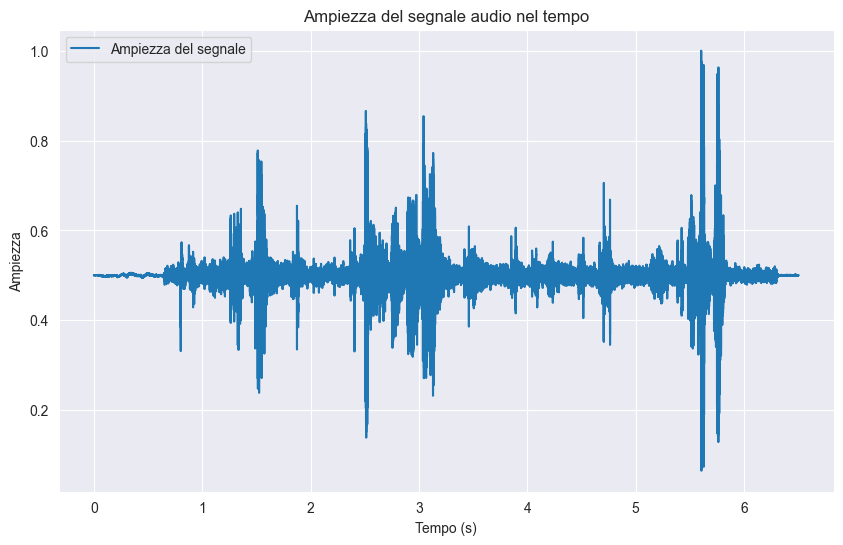

Processing audio files: 100%|██████████| 1/1 [00:07<00:00,  7.63s/it]

Tutti gli spettrogrammi sono stati generati e salvati come immagini.


In [33]:
# Importazione delle librerie necessarie
import os
import numpy as np
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
import librosa.display
from pydub import AudioSegment
from tqdm import tqdm  # Importa la libreria tqdm per la progress bar
# Definizione delle directory di input e output
input_dir = 'dataset_1/Target/Acoustic Harassment Devices'
output_dir = 'NuovoDataset'

# Creare la directory di output se non esiste
os.makedirs(output_dir, exist_ok=True)

# Definizione della lunghezza desiderata in secondi e in campioni
desired_length_sec = 4  # Durata desiderata in secondi
sampling_rate = 192000  # Frequenza di campionamento (modifica se necessario)
desired_length_samples = int(desired_length_sec * sampling_rate)
# Lista per memorizzare i percorsi dei file audio
audio_files = []

# Scorrere ricorsivamente le cartelle nel dataset
for root, dirs, files in os.walk(input_dir):
    for file in files:
        if file.endswith('.wav') or file.endswith('.mp3'):
            audio_files.append(os.path.join(root, file))

# Visualizzare il numero di file audio trovati
print(f"Numero di file audio trovati: {len(audio_files)}")
from pydub.effects import normalize
# Funzione per tagliare, generare e salvare gli spettrogrammi
def preprocess_audio(file, output_dir, desired_length_samples, sampling_rate):
    # Controlla l'estensione del file
    if file.endswith('.mp3'):
        audio = AudioSegment.from_mp3(file).set_frame_rate(sampling_rate).set_channels(1)
        y = np.array(audio.get_array_of_samples(), dtype=np.float32) / 32768.0  # Normalizzazione
        sr = audio.frame_rate
    else:  # file.endswith('.wav')
        y, sr = sf.read(file, always_2d=False)
        if len(y.shape) > 1:  # Se stereo, converte in mono
            y = librosa.to_mono(y.T)
        y = librosa.resample(y, orig_sr=sr, target_sr=sampling_rate)
        sr = sampling_rate
        
        
   
    # Normalizza l'audio tra 0 e 1
    y = (y / np.max(y) + 1) / 2 
 
   
    # Dividi l'audio in segmenti di 4 secondi
    for i in range(0, len(y), desired_length_samples):
        segment = y[i:i + desired_length_samples]
        if len(segment) < desired_length_samples:
            segment = np.pad(segment, (0, desired_length_samples - len(segment)), mode='constant')
        
        # Creare lo spettrogramma utilizzando STFT
        D = np.abs(librosa.stft(segment))  # Magnitude of the STFT
        D_db = librosa.amplitude_to_db(D, ref=np.max)
        
        # Creare la struttura delle directory di output mantenendo la stessa gerarchia
        relative_path = os.path.relpath(file, input_dir)
        segment_output_dir = os.path.splitext(os.path.join(output_dir, relative_path))[0]
        os.makedirs(segment_output_dir, exist_ok=True)
        spectrogram_output_file = os.path.join(segment_output_dir, f'segment_{i // desired_length_samples}.png')
        
        # Salva lo spettrogramma come immagine
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(D_db, sr=sr, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Spectrogram (STFT)')
        plt.tight_layout()
        plt.savefig(spectrogram_output_file, bbox_inches='tight', pad_inches=0.1)
        plt.close()
# Preprocessamento di ciascun file audio con progress bar
with tqdm(total=len(audio_files), desc='Processing audio files') as progress_bar:
    for file in audio_files:
        preprocess_audio(file, output_dir, desired_length_samples, sampling_rate)
        progress_bar.update(1)

print("Tutti gli spettrogrammi sono stati generati e salvati come immagini.")